In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mag_calc import MagCalc
from tqdm import tqdm
from scipy import stats, linalg as la, optimize as opt
import pandas as pd

%matplotlib inline

In [2]:
plt.rcParams["figure.dpi"] = 150
plt.style.use('seaborn')

In [3]:
spins1 = np.load('spin_atom_arrays/1_1_1_spins.npy')
atoms1 = np.load('spin_atom_arrays/1_1_1_atoms.npy')

spins2 = np.load('spin_atom_arrays/1_-1_0_spins.npy')
atoms2 = np.load('spin_atom_arrays/1_-1_0_atoms.npy')

In [4]:
orientations = spins1 * np.sqrt(3)
orientations

array([[ 1.,  1.,  1.],
       [-1., -1., -1.],
       [ 1.,  1.,  1.],
       ...,
       [ 1.,  1.,  1.],
       [-1., -1., -1.],
       [-1., -1., -1.]])

In [5]:
split = 11490 // 5
num_spins = len(spins1)

indicies = np.random.permutation(num_spins)

temp_spins1 = np.abs(spins1.copy())
temp_spins1[indicies[:split]] *= .5
temp_spins1[indicies[split:split * 2]] *= 1.5
temp_spins1[indicies[-split * 2:]] *= 0

temp_spins2 = np.abs(spins2.copy())
temp_spins2[indicies[:split]] *= .5
temp_spins2[indicies[split:split * 2]] *= 1.5
temp_spins2[indicies[-split * 2:]] *= 0

spin_list = [temp_spins1, temp_spins2]

In [6]:
calc1 = MagCalc(atoms=atoms1, 
               spins=temp_spins1*orientations, 
               g_factor=2, 
               spin=1, 
               magneton='mu_B')
calc2 = MagCalc(atoms=atoms2,
               spins=temp_spins2*orientations,
               g_factor=2,
               spin=1,
               magneton='mu_B')
calc_list = [calc1, calc2]

In [22]:
%%time

resolution = 40
side_length = 20

calc1.spins = np.abs(calc1.spins[np.random.permutation(num_spins)]) * orientations
plane = calc1.make_plane(center_point=np.array([0,0,1.1]),
                         mask_radius=8,
                         resolution=resolution,
                         side_length=side_length)

CPU times: user 14min 51s, sys: 2.11 s, total: 14min 53s
Wall time: 15min 4s


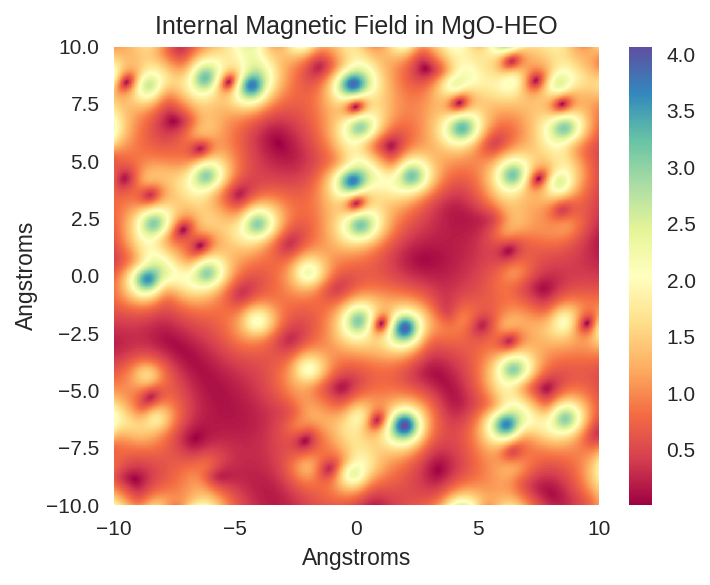

In [23]:
a = np.linspace(-side_length/2, side_length/2, resolution*side_length)
b = np.linspace(-side_length/2, side_length/2, resolution*side_length)
A,B = np.meshgrid(a,b)

plt.pcolormesh(A, B, plane, cmap='Spectral')
plt.gcf().set_size_inches(5,4)
plt.title('Internal Magnetic Field in MgO-HEO')
plt.colorbar()
plt.xlabel('Angstroms')
plt.ylabel('Angstroms')
# plt.axis('off')
plt.tight_layout()
# plt.savefig('distributions/other/mag_field', dpi=250)
plt.show()

In [7]:
magnitudes = [.75, 1, 1.25, 1.5]

loc1 = np.array([1, 1, 1])
loc2 = np.array([1, 1, -1])
loc3 = np.array([1, -1, 1])
loc4 = np.array([1, -1, -1])
loc5 = np.array([-1, 1, 1])
loc6 = np.array([-1, 1, -1])
loc7 = np.array([-1, -1, 1])
loc8 = np.array([-1, -1, -1])

locs = [loc1, loc2, loc3, loc4, loc5, loc6, loc7, loc8]

In [8]:
#                 th = np.arccos(np.random.uniform(-1,1))
#                 phi = np.random.uniform(-np.pi,np.pi)
#                 randomBasisVec = np.array([np.cos(phi)*np.sin(th),np.sin(phi)*np.sin(th),np.cos(th)])
#                 calc.spins[up] = randomBasisVec
#                 calc.spins[~up] = -randomBasisVec

In [9]:
def plot_fields(field_df, 
                bins, 
                magnitude, 
                basis,
                location, 
                save=True,
                plot=True):
    
    for i, col in enumerate(field_df.columns):
        plt.subplot(2,2,i+1)
        plt.hist(field_df[col], bins=bins, density=True)
        plt.title(col)
        
        if col == 'Magnitude':
            plt.xlim(0, 2.5)
            plt.ylim(0, 1.75)
        else:
            plt.xlim(-1.5, 1.5)
            plt.ylim(0, 1.75)
    
    plt.suptitle('Magnitude: {}, Basis: {}, Location: {}'.format(magnitude, basis, tuple(location.tolist())))
    plt.tight_layout(rect = [0, .03, 1, .95])
    plt.gcf().set_size_inches(10,6)
    
    if save is True:
        plt.savefig('distributions/dist/mag_{}_basis_{}_loc_{}'.format(int(magnitude*100), basis, tuple(location.tolist())), dpi=150)
        
    if plot is True:
        plt.show()
    else:
        plt.clf()

In [38]:
%%time

n = int(1e5) 
bins = 50
bases = ['(1,1,1)', '(1,-1,0)']
save = True
plot = False


for basis, calc, spins in zip(bases, calc_list, spin_list):
    for i, magnitude in enumerate(magnitudes):
        mag = magnitude / np.sqrt(3)
    
        for j, location in enumerate(locs):
            loc = location * mag
            mask = calc.make_mask(loc.reshape(1,-1), 12)
            fields = []
            field_comps = []
        
            for k in tqdm(range(n)):
                orientations *= -1
                calc.spins = np.abs(calc.spins[np.random.permutation(num_spins)]) * orientations
                field = calc.calculate_field(loc, return_vector=True, mask=mask)
                fields.append((la.norm(field), *field))
                
            field_df = pd.DataFrame(columns=['Magnitude', 'X', 'Y', 'Z'], data=fields)
            
            if save is True:
                field_df.to_csv('distributions/data/mag_{}_basis_{}_loc_{}'.format(int(magnitude*100), basis, tuple(location.tolist())), index=False)
            
            plot_fields(field_df, 
                        bins,
                        magnitude,
                        basis,
                        location,
                        save,
                        plot)

100%|██████████| 100000/100000 [01:24<00:00, 1181.49it/s]


CPU times: user 1h 15min 46s, sys: 20.5 s, total: 1h 16min 7s
Wall time: 2h 13min 56s


<Figure size 1500x900 with 0 Axes>

In [10]:
def make_rand_spins():
    phi = np.random.uniform(-np.pi, np.pi, num_spins)
    theta = np.arccos(np.random.uniform(-1, 1, num_spins))

    return np.array([np.sin(theta)* np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)]).T

In [13]:
random_spins = make_rand_spins()

In [18]:
%%time

fields = []
n = int(1e6)
location = np.ones(3) * .1
rand_calc = MagCalc(atoms=atoms1, spins=random_spins, g_factor=2, spin=1, magneton='mu_B')
mask = rand_calc.make_mask(location.reshape(1,-1), 12)

for i in tqdm(range(n)):
    rand_calc.spins = rand_calc.spins[np.random.permutation(num_spins)]
#     rand_calc.spins = make_rand_spins() * 2 * 9.274009994e-24
    
    field = rand_calc.calculate_field(location, return_vector=False, mask=mask)
    fields.append(field)

100%|██████████| 1000000/1000000 [11:44<00:00, 1419.58it/s]

CPU times: user 11min 44s, sys: 2.79 s, total: 11min 47s
Wall time: 11min 44s


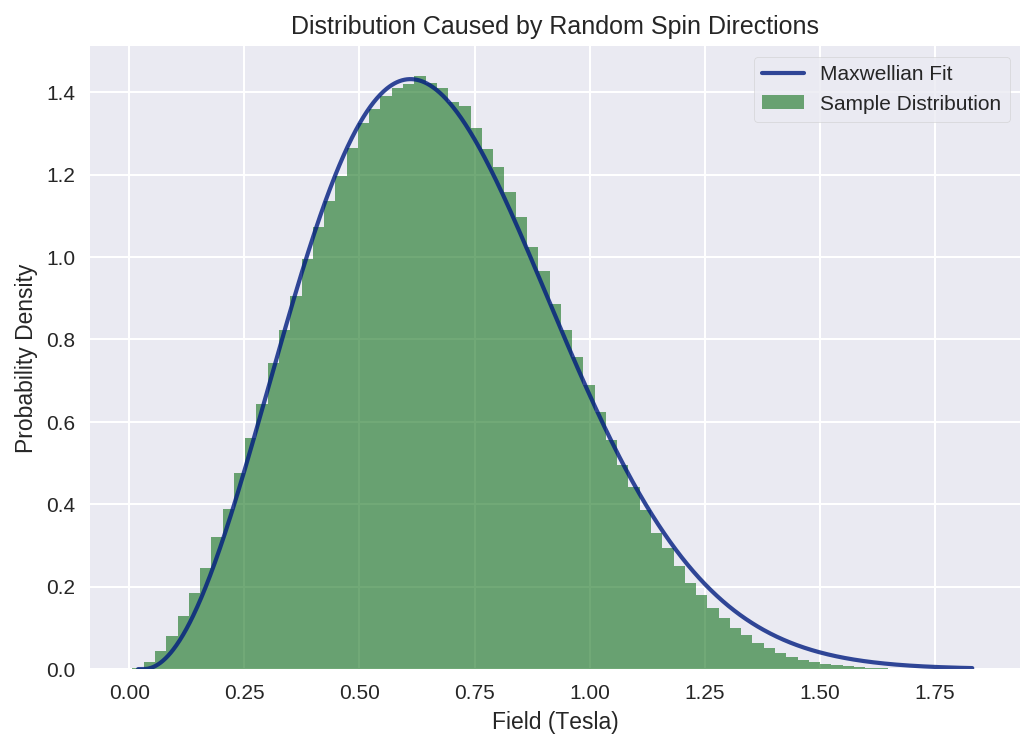

In [34]:
cpal = sns.color_palette('dark')

y,x,_ = plt.hist(fields, bins=75, density=True, alpha=.6, color=cpal[2], label='Sample Distribution')
x = (x[:-1] + x[1:])/2

f = lambda params: stats.maxwell.pdf(x, loc=params[0], scale=params[1]) - y
mean, sd = opt.least_squares(f, np.array([0,1]))['x']
domain = np.linspace(x.min(), x.max(), 1000)
plt.plot(domain, stats.maxwell.pdf(domain, loc=mean, scale=sd), lw=2, c=cpal[0], alpha=0.8, label='Maxwellian Fit')

plt.title('Distribution Caused by Random Spin Directions')
plt.xlabel('Field (Tesla)')
plt.ylabel('Probability Density')
plt.legend(frameon=True)
# plt.savefig('distributions/other/random_spin_dist_fit', dpi=200)
plt.show()

In [109]:
%%time

fields = []
n = int(1e6)
location = np.ones(3) * 1.6
mask = calc1.make_mask(location.reshape(1,-1), 12)

for i in tqdm(range(n)):
    orientations *= 1
    calc1.spins = np.abs(calc1.spins[np.random.permutation(11489)]) * orientations
    
    field = calc1.calculate_field(location, return_vector=True, mask=mask)
    fields.append((la.norm(field), *field))
#     fields.append(field)
field_df = pd.DataFrame(columns=['Magnitude', 'X', 'Y', 'Z'], data=fields)

100%|██████████| 1000000/1000000 [11:43<00:00, 1421.43it/s]


CPU times: user 11min 44s, sys: 2.2 s, total: 11min 46s
Wall time: 11min 44s


In [122]:
mag = field_df['Magnitude'].to_numpy()
peak1 = mag[(mag<1)]
peak2 = mag[(mag>1)*(mag<3)]
peak3 = mag[(mag>3)*(mag<6)]
peak4 = mag[(mag>6)]

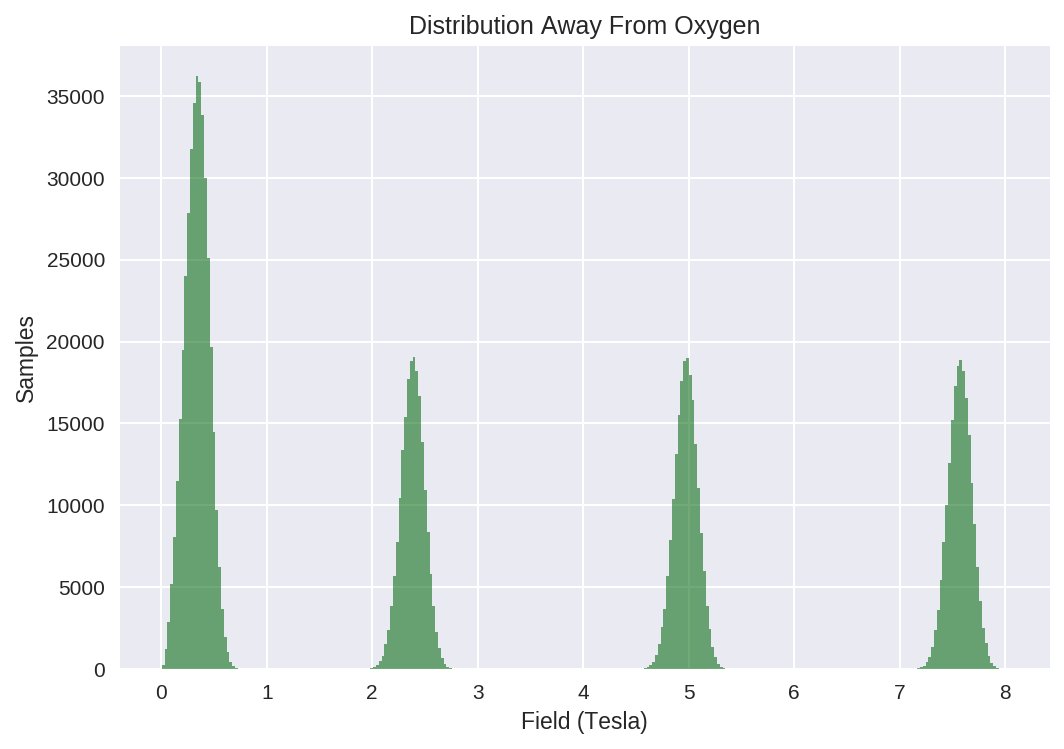

In [151]:
plt.hist(field_df['Magnitude'], bins=300, density=True, color=cpal[2], alpha=0.6)
plt.title('Distribution Away From Oxygen')
plt.xlabel('Field (Tesla)')
plt.ylabel('Probability Density')
plt.savefig('distributions/other/distribution_with_peaks', dpi=200)
plt.show()

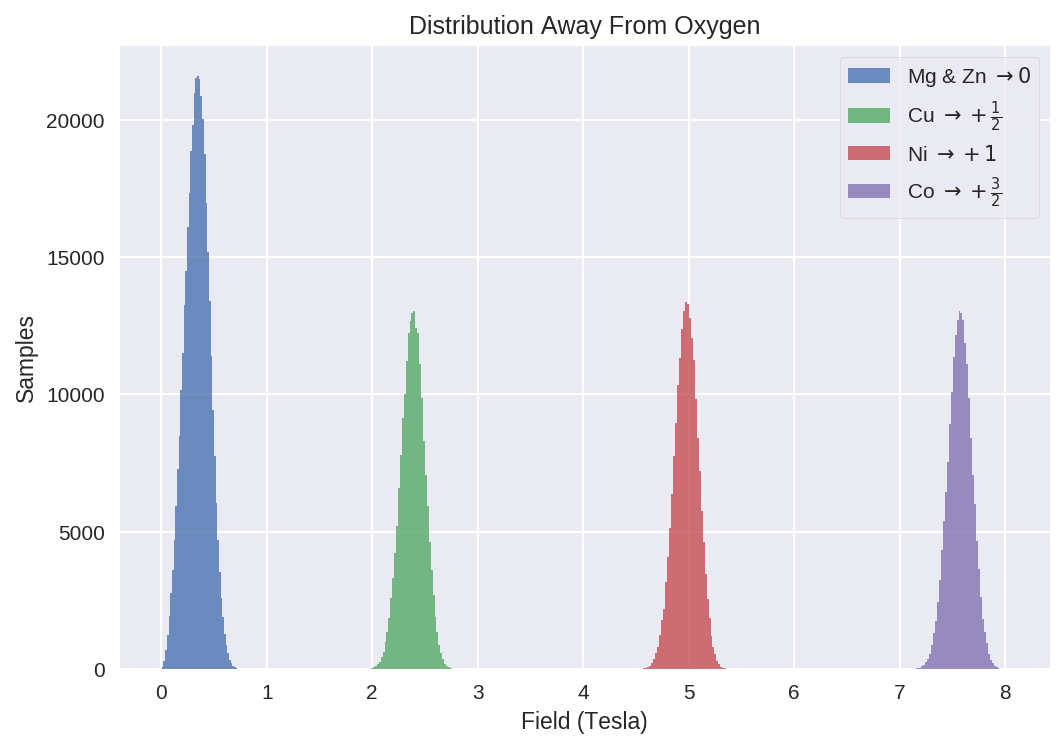

In [153]:
alpha=0.8

plt.hist(peak1, bins=50, alpha=alpha, label=r'Mg & Zn $\rightarrow 0$')
plt.hist(peak2, bins=50, alpha=alpha, label=r'Cu $\rightarrow +\frac{1}{2}$')
plt.hist(peak3, bins=50, alpha=alpha, label=r'Ni $\rightarrow +1$')
plt.hist(peak4, bins=50, alpha=alpha, label=r'Co $\rightarrow +\frac{3}{2}$')
plt.legend(frameon=True)
plt.title('Distribution Away From Oxygen')
plt.xlabel('Field (Tesla)')
plt.ylabel('Samples')
plt.savefig('distributions/other/distribution_with_colored_peaks', dpi=200)
plt.show()